In [29]:
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import seaborn as sns
import torch
import torch.distributions as dist
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [30]:
%config InlineBackend.figure_format='retina'
sns.set()

In [31]:
def safe_log(z):
    return torch.log(z + 1e-7)

In [32]:
class FreeEnergyBound(nn.Module):

    def __init__(self, density):
        super().__init__()

        self.density = density

    def forward(self, zk, log_jacobians):

        sum_of_log_jacobians = sum(log_jacobians)
        return (-sum_of_log_jacobians - safe_log(self.density(zk))).mean()

In [33]:
class NormalizingFlow(nn.Module):

    def __init__(self, dim, flow_length):
        super().__init__()

        self.transforms = nn.Sequential(*(
            PlanarFlow(dim) for _ in range(flow_length)
        ))

        self.log_jacobians = nn.Sequential(*(
            PlanarFlowLogDetJacobian(t) for t in self.transforms
        ))

    def forward(self, z):

        log_jacobians = []

        for transform, log_jacobian in zip(self.transforms, self.log_jacobians):
            log_jacobians.append(log_jacobian(z))
            z = transform(z)

        zk = z

        return zk, log_jacobians


class PlanarFlow(nn.Module):

    def __init__(self, dim):
        super().__init__()

        self.weight = nn.Parameter(torch.Tensor(1, dim))
        self.bias = nn.Parameter(torch.Tensor(1))
        self.scale = nn.Parameter(torch.Tensor(1, dim))
        self.tanh = nn.Tanh()

        self.reset_parameters()

    def reset_parameters(self):

        self.weight.data.uniform_(-0.01, 0.01)
        self.scale.data.uniform_(-0.01, 0.01)
        self.bias.data.uniform_(-0.01, 0.01)

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        return z + self.scale * self.tanh(activation)


class PlanarFlowLogDetJacobian(nn.Module):
    """A helper class to compute the determinant of the gradient of
    the planar flow transformation."""

    def __init__(self, affine):
        super().__init__()

        self.weight = affine.weight
        self.bias = affine.bias
        self.scale = affine.scale
        self.tanh = affine.tanh

    def forward(self, z):

        activation = F.linear(z, self.weight, self.bias)
        psi = (1 - self.tanh(activation) ** 2) * self.weight
        det_grad = 1 + torch.mm(psi, self.scale.t())
        return safe_log(det_grad.abs())

In [34]:
def p_z(z):

    z1, z2 = torch.chunk(z, chunks=2, dim=1)
    norm = torch.sqrt(z1 ** 2 + z2 ** 2)

    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.8) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.8) ** 2)
    u = 0.5 * ((norm - 4) / 0.4) ** 2 - torch.log(exp1 + exp2)

    return torch.exp(-u)

In [35]:
def random_normal_samples(n, dim=2):
    return torch.zeros(n, dim).normal_(mean=0, std=1)

In [36]:
def train(flow_length=16, epochs=10000, initial_lr=0.01, lr_decay=0.999, batch_size=40):
    
    flow = NormalizingFlow(dim=2, flow_length=flow_length)
    bound = FreeEnergyBound(density=p_z)
    optimizer = optim.RMSprop(flow.parameters(), lr=initial_lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, lr_decay)
    
    hist_loss = np.zeros(epochs)
    
    with tqdm(total=epochs) as pbar:
        
        for i in range(epochs):

            samples = Variable(random_normal_samples(batch_size))
            zk, log_jacobians = flow(samples)

            optimizer.zero_grad()
            loss = bound(zk, log_jacobians)
            loss.backward()
            optimizer.step()
            
            scheduler.step()
            
            if i % 50 == 0:
                pbar.set_postfix({'loss': loss.item()})

            pbar.update()
            
            hist_loss[i] = loss.item()
            
    return flow, hist_loss

In [37]:
flow, hist_loss = train()

  0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
def scatter_points(points):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    fig = plt.figure(figsize=(7, 7))
    ax = fig.add_subplot(111)
    ax.scatter(points[:, 0], points[:, 1], alpha=0.7, s=25)
    ax.set_xlim(*X_LIMS)
    ax.set_ylim(*Y_LIMS)

    plt.show()


def plot_density(density):

    X_LIMS = (-7, 7)
    Y_LIMS = (-7, 7)

    x1 = np.linspace(*X_LIMS, 300)
    x2 = np.linspace(*Y_LIMS, 300)
    x1, x2 = np.meshgrid(x1, x2)
    shape = x1.shape
    x1 = x1.ravel()
    x2 = x2.ravel()

    z = np.c_[x1, x2]
    z = torch.from_numpy(z)

    density_values = density(z).data.numpy().reshape(shape)

    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(density_values, extent=(*X_LIMS, *Y_LIMS))
    ax.set_title("True density")
    plt.show()

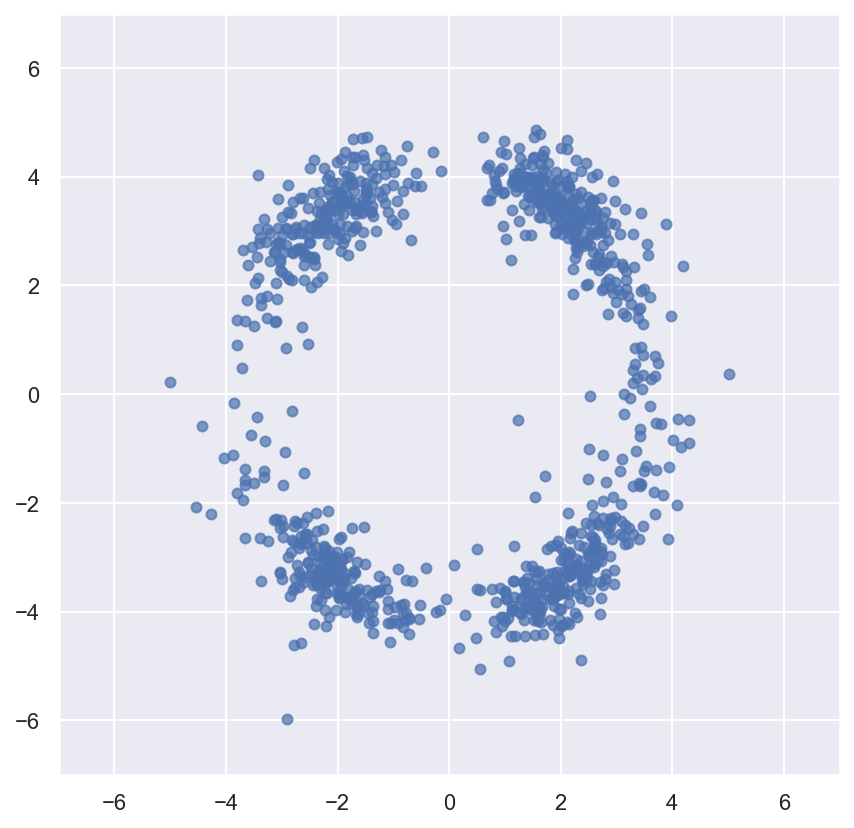

In [52]:
samples = random_normal_samples(1000)
zk, det_grads = flow(samples)
scatter_points(
    zk.data.numpy())

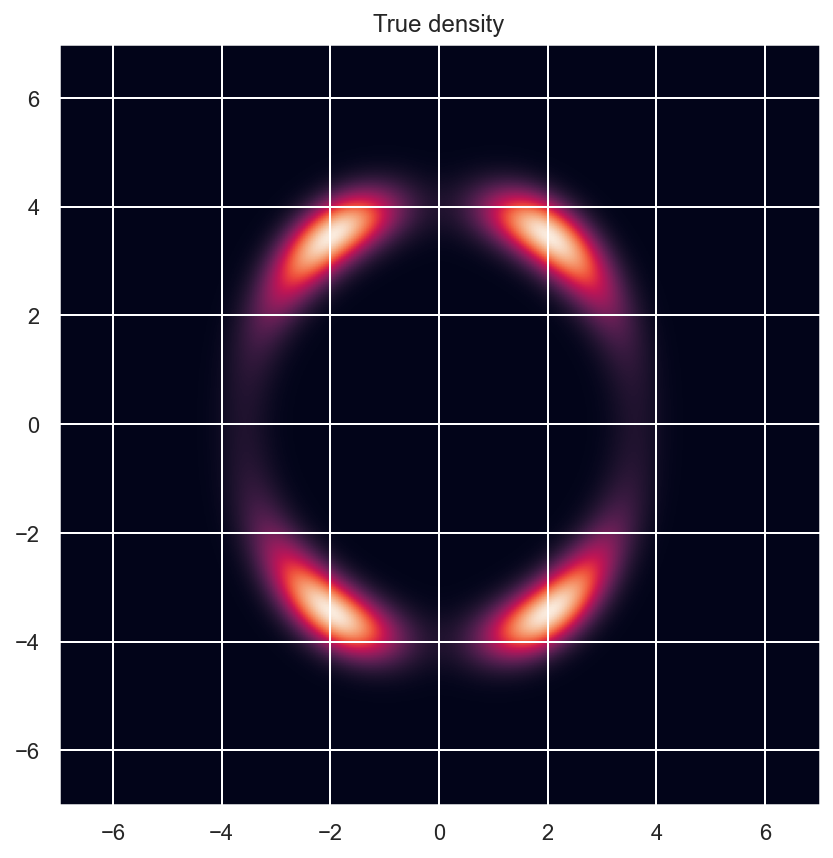

In [53]:
plot_density(p_z)